## Load In Dependencies

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
from odc.algo import to_rgba
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('xxxxxxxxxxxxxxxxxxxxxxx')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

## Data

In [2]:
crop_presence_data = pd.read_csv("Crop_Location_Data_20221201.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


### Accessing the Sentinel-1 Data

In [3]:
def get_sentinel_data(latlong,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    box_size_deg = 0.00056 # Surrounding box in degrees, yields approximately 7x7 pixel region

    min_lon = float(float(latlong[1])-box_size_deg/2)
    min_lat = float(float(latlong[0])-box_size_deg/2)
    max_lon = float(float(latlong[1])+box_size_deg/2)
    max_lat = float(float(latlong[0])+box_size_deg/2)

    bbox_of_interest = (min_lon, min_lat, max_lon, max_lat)
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest
    )
    items = list(search.get_all_items())
    bands_of_interest = assests
    data = stac_load([items[0]], patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
    vh = data["vh"].astype("float").values.tolist()[0][0]
    vv = data["vv"].astype("float").values.tolist()[0][0]
    return vh,vv

In [4]:
## Function call to extract VV,VH Values
time_slice = "2023-03-20/2024-02-20"
assests = ['vh','vv']
vh_vv = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    vh_vv.append(get_sentinel_data(coordinates,time_slice,assests))
vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv'])

100%|██████████| 600/600 [02:21<00:00,  4.25it/s]


In [5]:
vh_vv_data

,vh,vv
0,0.014181,0.052517
1,0.018286,0.052303
2,0.020614,0.045859
3,0.018250,0.053146
4,0.011184,0.084344
...,...,...
595,0.033005,0.217440
596,0.101858,0.344579
597,0.058315,0.345032
598,0.151695,0.298555


## Joining the predictor variables and response variables

In [6]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [7]:
crop_data = combine_two_datasets(crop_presence_data,vh_vv_data)
crop_data.head()

,Latitude and Longitude,Class of Land,vh,vv
0,"(10.323727047081501, 105.2516346045924)",Rice,0.014181,0.052517
1,"(10.322364360592521, 105.27843410554115)",Rice,0.018286,0.052303
2,"(10.321455902933202, 105.25254306225168)",Rice,0.020614,0.045859
3,"(10.324181275911162, 105.25118037576274)",Rice,0.018250,0.053146
4,"(10.324635504740822, 105.27389181724476)",Rice,0.011184,0.084344


In [8]:
crop_data = crop_data[['vh','vv','Class of Land']]

In [9]:
crop_data

,vh,vv,Class of Land
0,0.014181,0.052517,Rice
1,0.018286,0.052303,Rice
2,0.020614,0.045859,Rice
3,0.018250,0.053146,Rice
4,0.011184,0.084344,Rice
...,...,...,...
595,0.033005,0.217440,Non Rice
596,0.101858,0.344579,Non Rice
597,0.058315,0.345032,Non Rice
598,0.151695,0.298555,Non Rice


### Train and Test Split 

In [10]:
X = crop_data.drop(columns=['Class of Land']).values
y = crop_data ['Class of Land'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=40)

### Feature Scaling 

In [11]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Define scaling techniques
scaling_techniques = [
    ('StandardScaler', StandardScaler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('RobustScaler', RobustScaler())
]

# Define classifiers and their corresponding models
classifiers = [
    ('LogisticRegression', LogisticRegression(max_iter=1000)),
    ('DecisionTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier()),
    ('SVM', SVC()),
    ('KNN', KNeighborsClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('AdaBoost', AdaBoostClassifier())

]

# Initialize variables to store the best performing combination
best_score = 0
best_scaling_technique = None
best_classifier = None

# Loop through each scaling technique
for scaler_name, scaler in scaling_techniques:
    print(f'Scaling Technique: {scaler_name}')
    print('-----------------------------------')
    
    # Apply the scaling technique to the training and testing data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Loop through each classifier
    for clf_name, clf in classifiers:
        # Perform cross-validation with the classifier
        scores = cross_val_score(clf, X_train_scaled, y_train, cv=5)
        
        # Calculate the mean cross-validation score
        mean_score = np.mean(scores)
        
        # Print the mean cross-validation score for this classifier
        print(f'{clf_name}: Mean Cross-Validation Score = {mean_score:.2f}')
        
        # Update the best performing combination if needed
        if mean_score > best_score:
            best_score = mean_score
            best_scaling_technique = scaler_name
            best_classifier = clf_name
    
    print('\n')

# Print the best performing combination
print(f'Best Performing Combination:')
print(f'Scaling Technique: {best_scaling_technique}')
print(f'Classifier: {best_classifier}')
print(f'Mean Cross-Validation Score: {best_score:.2f}')

Scaling Technique: StandardScaler
-----------------------------------
LogisticRegression: Mean Cross-Validation Score = 0.72
DecisionTree: Mean Cross-Validation Score = 0.82
RandomForest: Mean Cross-Validation Score = 0.85
SVM: Mean Cross-Validation Score = 0.88
KNN: Mean Cross-Validation Score = 0.87
GradientBoosting: Mean Cross-Validation Score = 0.86
AdaBoost: Mean Cross-Validation Score = 0.86


Scaling Technique: MinMaxScaler
-----------------------------------
LogisticRegression: Mean Cross-Validation Score = 0.73
DecisionTree: Mean Cross-Validation Score = 0.82
RandomForest: Mean Cross-Validation Score = 0.85
SVM: Mean Cross-Validation Score = 0.88
KNN: Mean Cross-Validation Score = 0.87
GradientBoosting: Mean Cross-Validation Score = 0.86
AdaBoost: Mean Cross-Validation Score = 0.86


Scaling Technique: RobustScaler
-----------------------------------
LogisticRegression: Mean Cross-Validation Score = 0.72
DecisionTree: Mean Cross-Validation Score = 0.82
RandomForest: Mean Cross

In [12]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model Training

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

def model_evaluation(X_train, y_train, X_test, y_test):
    models = {
        'LogisticRegression': LogisticRegression(),
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'SVM': SVC(),
        'KNN': KNeighborsClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        'AdaBoost': AdaBoostClassifier()
    }
    params = {
        'LogisticRegression': {'solver': ['lbfgs'], 'C': [1.0, 0.5, 0.1]},
        'DecisionTree': {'max_depth': [None, 10, 20, 30]},
        'RandomForest': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30]},
        'SVM': {'C': [1, 0.1, 0.01,2], 'kernel': ['rbf', 'linear']},
        'KNN': {'n_neighbors': [2,3, 5, 7, 9]},
        'GradientBoosting': {'n_estimators': [100,150,200,250], 'learning_rate': [0.1, 0.05, 0.01]},
        'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]}
    }
    best_estimators = {}
    for name in models.keys():
        clf = GridSearchCV(models[name], params[name], cv=5, scoring='accuracy')
        clf.fit(X_train, y_train)
        best_estimators[name] = clf.best_estimator_
        print(f"{name} best parameters: {clf.best_params_}")
        print(f"{name} best score: {clf.best_score_:.2f}%")
    # Evaluate models on the test set
    for name, estimator in best_estimators.items():
        y_pred = estimator.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Test Set Accuracy: {accuracy:.2f}%")
    return best_estimators

In [14]:
# Call the model_evaluation function to get the best estimators
best_estimators = model_evaluation(X_train, y_train, X_test, y_test)

# Make predictions on the training data using the best estimators
for name, estimator in best_estimators.items():
    insample_predictions = estimator.predict(X_train)
    insample_accuracy = accuracy_score(y_train, insample_predictions)
    print(f"{name} Training Set Accuracy: {insample_accuracy:.2f}%")


LogisticRegression best parameters: {'C': 0.1, 'solver': 'lbfgs'}
LogisticRegression best score: 0.72%
DecisionTree best parameters: {'max_depth': 30}
DecisionTree best score: 0.83%
RandomForest best parameters: {'max_depth': 10, 'n_estimators': 10}
RandomForest best score: 0.87%
SVM best parameters: {'C': 1, 'kernel': 'rbf'}
SVM best score: 0.88%
KNN best parameters: {'n_neighbors': 9}
KNN best score: 0.88%
GradientBoosting best parameters: {'learning_rate': 0.05, 'n_estimators': 100}
GradientBoosting best score: 0.87%
AdaBoost best parameters: {'learning_rate': 0.01, 'n_estimators': 200}
AdaBoost best score: 0.87%
LogisticRegression Test Set Accuracy: 0.71%
DecisionTree Test Set Accuracy: 0.86%
RandomForest Test Set Accuracy: 0.89%
SVM Test Set Accuracy: 0.89%
KNN Test Set Accuracy: 0.89%
GradientBoosting Test Set Accuracy: 0.88%
AdaBoost Test Set Accuracy: 0.87%
LogisticRegression Training Set Accuracy: 0.73%
DecisionTree Training Set Accuracy: 1.00%
RandomForest Training Set Accura

In [34]:
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

# Create the SVM model
svm = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the optimal parameters
print("Optimal Parameters:", grid_search.best_params_)

# Evaluate the model on the test set
print("Test set accuracy:", grid_search.score(X_test, y_test))

Optimal Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Test set accuracy: 0.8944444444444445


In [35]:
from sklearn.svm import SVC
model=SVC(C=1, kernel='rbf', gamma='scale')
model.fit(X_train, y_train)

SVC(C=1)

## Model Evaluation

### In-Sample Evaluation

In [36]:
insample_predictions = model.predict(X_train)

In [37]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

Insample Accuracy 88.33%
              precision    recall  f1-score   support

    Non Rice       0.89      0.88      0.88       211
        Rice       0.88      0.89      0.88       209

    accuracy                           0.88       420
   macro avg       0.88      0.88      0.88       420
weighted avg       0.88      0.88      0.88       420



In [38]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

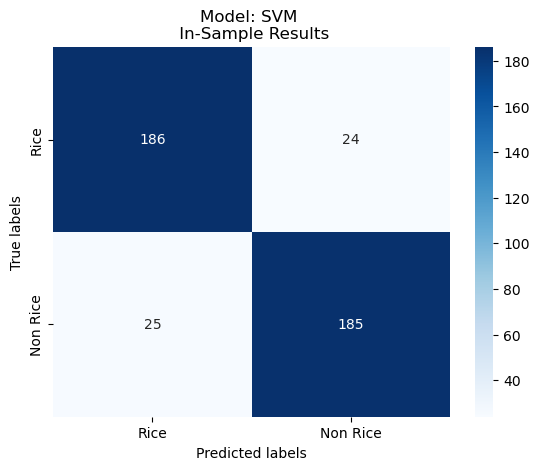

In [39]:
plot_confusion_matrix(y_train,insample_predictions,"Model: SVM \n In-Sample Results",['Rice', 'Non Rice'])

### Out-Sample Evaluation

In [40]:
outsample_predictions = model.predict(X_test)

In [41]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))

Accuracy 89.44%
              precision    recall  f1-score   support

    Non Rice       0.92      0.87      0.89        90
        Rice       0.87      0.92      0.90        90

    accuracy                           0.89       180
   macro avg       0.90      0.89      0.89       180
weighted avg       0.90      0.89      0.89       180



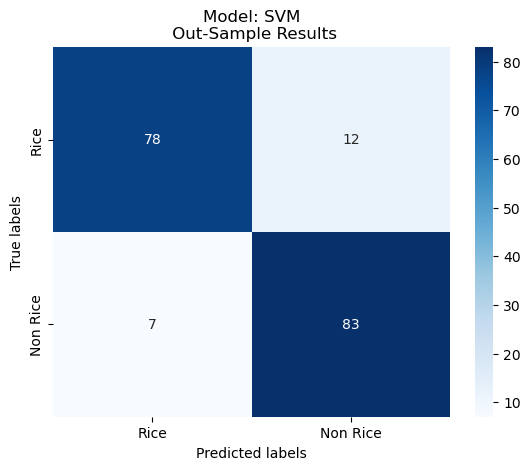

In [42]:
plot_confusion_matrix(y_test, outsample_predictions,"Model: SVM\n Out-Sample Results",['Rice', 'Non Rice'])

## Submission

In [43]:
#Reading the coordinates for the submission
test_file = pd.read_csv('challenge_1_submission_template.csv')
test_file.head()

,Latitude and Longitude,Class of Land
0,"(10.18019073690894, 105.32022315786804)",NaN
1,"(10.561107033461816, 105.12772097986661)",NaN
2,"(10.623790611954897, 105.13771401411867)",NaN
3,"(10.583364246115156, 105.23946127195805)",NaN
4,"(10.20744446668854, 105.26844107128906)",NaN


In [44]:
## Get Sentinel-1-RTC Data
time_slice = "2023-03-20/2024-02-20"
assests = ['vh','vv']
vh_vv = []
for coordinates in tqdm(test_file['Latitude and Longitude']):
    vh_vv.append(get_sentinel_data(coordinates,time_slice,assests))
submission_vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv'])

100%|██████████| 250/250 [01:10<00:00,  3.54it/s]


In [45]:
submission_vh_vv_data.head()

,vh,vv
0,0.016224,0.059835
1,0.023195,0.039707
2,0.057423,0.100502
3,0.003846,0.009788
4,0.017932,0.149586


In [46]:
# Feature Scaling 
submission_vh_vv_data = submission_vh_vv_data.values
transformed_submission_data = sc.transform(submission_vh_vv_data)

In [47]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [48]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'id':test_file['Latitude and Longitude'].values, 'target':final_prediction_series.values})

In [49]:
#Displaying the sample submission dataframe
display(submission_df)

,id,target
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Rice
2,"(10.623790611954897, 105.13771401411867)",Non Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Non Rice


In [50]:
#Dumping the predictions into a csv file.
submission_df.to_csv("challenge_1_submission_rice_crop_prediction.csv",index = False)